In [16]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.1.0'

In [17]:
import os
import lib
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, concatenate, Input, Conv2D,Flatten
from tensorflow.keras.backend import clear_session

from importlib import reload
reload(lib)

import warnings
warnings.filterwarnings('ignore')

In [18]:
data_dir = "/home/user/DeepLearning/projects/datasets/leaf_classification/"

### Read data from the CSV file

In [19]:
#here we split the data
split=0.7
X_train_f, _, X_train_ri, y_train, X_test_f, _, X_test_ri, y_test, species, num_classes, _, _ = lib.get_splitted_data(data_dir=data_dir, check_id_sets=True, verbose=1, use_resize_images=True, split=split)

The intersection between train and test set is 0
There are 99 classes for the classification task.


### Target onehot 

In [20]:
y_train_oh = np.eye(99)[y_train]#num_classes
y_test_oh  = np.eye(num_classes)[y_test]

In [21]:
X_train_ri = X_train_ri.reshape((X_train_ri.shape[0], X_train_ri.shape[1], X_train_ri.shape[2], 1))

In [22]:
X_train_f.shape, X_train_ri.shape, y_train_oh.shape

((693, 194), (693, 128, 128, 1), (693, 99))

In [23]:
X_test_f.shape, X_test_ri.shape, y_test_oh.shape

((297, 194), (297, 128, 128), (297, 99))

In [24]:
x_trainif = np.r_[[i.flatten() for i in X_train_ri]]
x_testif  = np.r_[[i.flatten() for i in X_test_ri]]

In [25]:
x_trainif.shape, x_testif.shape

((693, 16384), (297, 16384))

In [26]:
from tensorflow.keras import Model
from tensorflow.keras.activations import relu, sigmoid, tanh, linear, softmax
from progressbar import progressbar as pbar
from scipy.stats import gaussian_kde


### Set up a model with Keras and train 

In [27]:

class MyModel(Model):
    def __init__(self, bn1=False, bn2=False):
        super(MyModel, self).__init__()
        self.bn1 = bn1
        self.bn2 = bn2
            
    def build(self, input_shape):
        
        self.w1 = self.add_weight(shape=(input_shape[-1], 100), initializer='random_normal', trainable=True, dtype=tf.float32)
        self.b1 = self.add_weight(shape=(100, ), initializer='random_normal', trainable=True, dtype=tf.float32)    
        
        self.w2 = self.add_weight(shape=(100, 100), initializer='random_normal', trainable=True, dtype=tf.float32)
        self.b2 = self.add_weight(shape=(100, ), initializer='random_normal', trainable=True, dtype=tf.float32)
        
        self.w3 = self.add_weight(shape=(100,99 ), initializer='random_normal', trainable=True, dtype=tf.float32)
        self.b3 = self.add_weight(shape=(99, ), initializer='random_normal', trainable=True, dtype=tf.float32)        

        
    @tf.function
    def get_z1(self, X):
        return tf.matmul(X,self.w1)+self.b1
                
    @tf.function
    def get_z2(self, X):
        z1 = self.get_z1(X)
        a1 = relu(z1)
        return tf.matmul(a1,self.w2)+self.b2
    
    @tf.function
    def get_z3(self, X):
        z2 = self.get_z2(X)
        a2 = relu(z2)
        return tf.matmul(a2,self.w3)+self.b3
        
    @tf.function
    def call(self, X):
        z3 = self.get_z3(X)
        a3 = softmax(z3)        
        return a3
        
    @tf.function
    def train_step(self, X,y):
        preds = model(X)
        with tf.GradientTape() as tape:
            loss_value = tf.reduce_mean(self.loss(model(X), y))
        grads = tape.gradient(loss_value, self.trainable_variables)

        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return loss_value

    def fit(self, X,y, epochs=10, batch_size=32):
        self.hloss = []
        self.hz1 = []
        self.hz2 = []
        self.hz3 = []
        for epoch in pbar(range(epochs)):
            idxs = np.random.permutation(len(X))
            for step in range(len(X)//batch_size+((len(X)%batch_size)!=0)):
                X_batch = X[idxs][step*batch_size:(step+1)*batch_size]
                y_batch = y[idxs][step*batch_size:(step+1)*batch_size]
                loss_value = self.train_step(X_batch, y_batch)
                self.hz1.append(self.get_z1(X_batch).numpy().flatten())
                self.hz2.append(self.get_z2(X_batch).numpy().flatten())
                self.hz3.append(self.get_z3(X_batch).numpy().flatten())
                self.hloss.append(loss_value)
    
    def score(self, X, y):
        return np.mean(model.predict(X).argmax(axis=1) == y)    
    
    def plot_hist(self):
        def plot_z_history(s):
            s = s[::5]
            for i,data in enumerate(pbar(s)):
                kde = gaussian_kde(data)
                xrange = np.linspace(np.min(data), np.max(data),100)
                plt.plot(xrange, kde(xrange)-i*.005, 
                         color=plt.cm.RdBu(255*i/len(s)), 
                         alpha=.5)
            plt.yticks([0,-i*.005], [0,len(model.hz1)]);
            plt.ylabel("step nb")
            plt.xlabel("activation")
            plt.grid();
        plt.figure(figsize=(15,3))
        plt.subplot(131)
        plt.plot(self.hloss); plt.grid(); plt.title("loss"); plt.xlabel("steps")
        plt.subplot(132)
        plot_z_history(self.hz1); plt.title("z1 (before activation function at layer 1)\nred signals the first epoch")
        plt.subplot(133)
        plot_z_history(self.hz3); plt.title("z2 (before activation function at layer 2)\nred signals the first epoch")

In [28]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import categorical_crossentropy


In [36]:
#instantiate the model
model = MyModel()
model.compile(optimizer='SGD', loss=categorical_crossentropy)
model.fit(x_trainif.astype(np.float32), np.eye(99)[y_train.astype(int)], epochs=10, batch_size=16)#x_train flatten and 
predict = lambda X: (model.predict(X)[:,0]>0.5).astype(int)
model.summary()

100% (10 of 10) |########################| Elapsed Time: 0:00:15 Time:  0:00:15


Model: "my_model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 1,658,599
Trainable params: 1,658,599
Non-trainable params: 0
_________________________________________________________________


N/A% (0 of 88) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

train accuracy 0.043
test  accuracy 0.040


100% (88 of 88) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (88 of 88) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


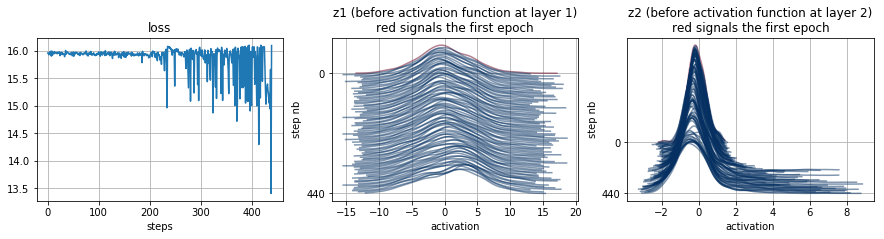

In [37]:
print ("train accuracy %.3f"%model.score(x_trainif, y_train))
print ("test  accuracy %.3f"%model.score(x_testif, y_test))
model.plot_hist()

In [17]:
block.summary()

NameError: name 'block' is not defined

In [18]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/no_normalization",histogram_freq=1)
# mymodel=get_model(3)
model1.fit(X_train_ri, y_train_oh, epochs=10, batch_size=128, callbacks=[tensorboard_callback])

NameError: name 'model1' is not defined